In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
from sklearn.datasets import make_blobs
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [6]:
# Генерация синтетических данных
X, y = make_blobs(n_samples=2000, n_features=18, centers=2, cluster_std=7.0, random_state=8)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y, random_state=8)

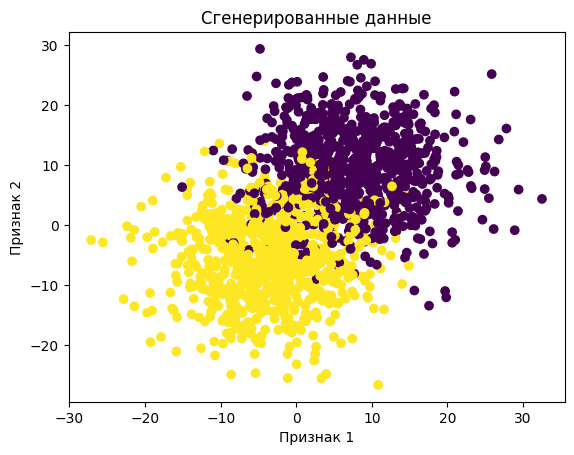

In [63]:
# Отображение первых двух признаков
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train)
plt.xlabel('Признак 1')
plt.ylabel('Признак 2')
plt.title('Сгенерированные данные')
plt.show()

In [15]:
data = pd.read_csv('data_preprocessed/data_combined_featured_4000.csv', index_col='Unnamed: 0')
X = data.drop(['Result'], axis=1)
y = data['Result']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=True, stratify=y, random_state=8)

scaler = StandardScaler().set_output(transform='pandas')
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [17]:
type(y_train)

pandas.core.series.Series

3 слоя

In [18]:
# Определение датасета
class SyntheticDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        x = self.X.iloc[idx].values  # получить значения строки
        y = self.y.iloc[idx]  # получить значение Series
        return {
            'x': torch.tensor(x, dtype=torch.float32),
            'y': torch.tensor(y, dtype=torch.long)
        }

# Определение нейронной сети
class FighterNet(nn.Module):
    def __init__(self):
        super(FighterNet, self).__init__()
        self.fc1 = nn.Linear(18, 128)  # входной слой
        self.fc2 = nn.Linear(128, 64)  # скрытый слой
        self.fc3 = nn.Linear(64, 2)  # выходной слой 

        nn.init.kaiming_normal_(self.fc1.weight)
        nn.init.kaiming_normal_(self.fc2.weight)              

    def forward(self, x):
        x = torch.relu(self.fc1(x))  # активация ReLU
        x = torch.relu(self.fc2(x))  # активация ReLU
        x = self.fc3(x)
        return x    

4 слоя

In [33]:
class FighterNet(nn.Module):
    def __init__(self):
        super(FighterNet, self).__init__()
        self.fc1 = nn.Linear(18, 128)  # входной слой
        self.fc2 = nn.Linear(128, 64)  # скрытый слой
        self.fc3 = nn.Linear(64, 32)  # скрытый слой
        self.fc4 = nn.Linear(32, 2)  # выходной слой

        nn.init.kaiming_normal_(self.fc1.weight)
        nn.init.kaiming_normal_(self.fc2.weight) 
        nn.init.kaiming_normal_(self.fc3.weight) 

    def forward(self, x):
        x = torch.relu(self.fc1(x))  # активация ReLU
        x = torch.relu(self.fc2(x))  # активация ReLU
        x = torch.relu(self.fc3(x))  # активация ReLU
        x = self.fc4(x)
        return x

In [19]:
# Создание датасета и даталоадера
train_dataset = SyntheticDataset(X_train, y_train)
test_dataset = SyntheticDataset(X_test, y_test)
batch_size = 32
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Инициализация нейронной сети и оптимизатора
net = FighterNet()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

# Обучение нейронной сети
for epoch in range(1):
    for batch in train_dataloader:
        x = batch['x']
        y = batch['y']
        optimizer.zero_grad()
        outputs = net(x)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()
    print(f'Эпоха {epoch+1}, потеря: {loss.item()}')

# Оценка нейронной сети
net.eval()
with torch.no_grad():
    total = 0
    correct = 0
    y_pred = []
    y_true = []
    for batch in test_dataloader:
        x = batch['x']
        y = batch['y']
        outputs = net(x)
        _, predicted = torch.max(outputs, 1)
        total += y.size(0)
        correct += (predicted == y).sum().item()
        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(y.cpu().numpy())
    accuracy = correct / total
    print(f'Точность: {accuracy:.4f}')
    f1 = f1_score(y_true, y_pred, average='weighted')
    print(f'F1: {f1:.4f}')

/home/neuralist/DS&ML/Data_Science/MIPT_Data_Scientist/DA & ML/UFC-predictor/.venv/lib/python3.12/site-packages/torch/autograd/graph.py:825: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 9010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Эпоха 1, потеря: 0.6292298436164856
Точность: 0.6290
F1: 0.6275


### Тестируем RNN

In [68]:
class MMADataSet(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = MMADataSet(X_train, y_train)
test_dataset = MMADataSet(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [69]:
# Модель RNN
class RNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(RNNModel, self).__init__()
        self.rnn = nn.RNN(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), self.rnn.hidden_size).to(x.device)
        out, _ = self.rnn(x.unsqueeze(1), h0)
        out = self.fc(out[:, -1, :])
        return torch.sigmoid(out)

Epoch 1, Loss: 3.552334148071954e-30
Матрица ошибок:

Classification report:
{'0.0': {'precision': 0.9900990099009901, 'recall': 1.0, 'f1-score': 0.9950248756218906, 'support': 200.0}, '1.0': {'precision': 1.0, 'recall': 0.99, 'f1-score': 0.9949748743718593, 'support': 200.0}, 'accuracy': 0.995, 'macro avg': {'precision': 0.995049504950495, 'recall': 0.995, 'f1-score': 0.9949998749968749, 'support': 400.0}, 'weighted avg': {'precision': 0.9950495049504952, 'recall': 0.995, 'f1-score': 0.9949998749968749, 'support': 400.0}}


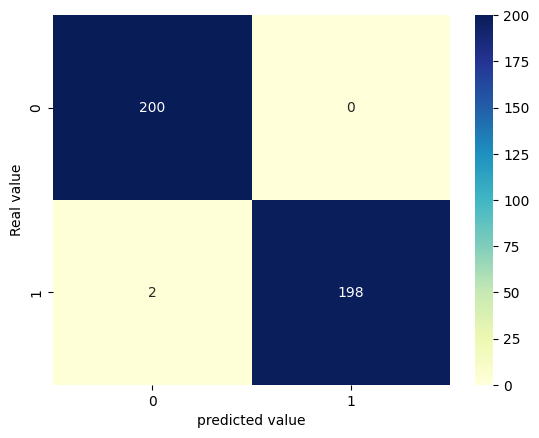

In [72]:
model = RNNModel(input_dim=X_train.shape[1], hidden_dim=128, output_dim=1)

# Обучение модели
criterion = nn.BCELoss()
optimizer = optim.Rprop(model.parameters(), lr=0.01)

for epoch in range(1):
    for batch in train_loader:
        inputs, labels = batch
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels)
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch+1}, Loss: {loss.item()}')

# Оценка модели
model.eval()
with torch.no_grad():
    total_correct = 0
    predicted_labels = []
    test_labels = []
    for batch in test_loader:
        inputs, labels = batch
        outputs = model(inputs)
        predicted = (outputs > 0.5).float()
        predicted_labels.extend(predicted.numpy().flatten())
        test_labels.extend(labels.numpy().flatten())

# Преобразовать списки в numpy массивы
predicted_labels = np.array(predicted_labels)
test_labels = np.array(test_labels)

# Матрица ошибок
conf_mat = confusion_matrix(test_labels, predicted_labels)
print("Матрица ошибок:")
sns.heatmap(conf_mat,  annot=True, fmt='d', cmap='YlGnBu')
plt.ylabel('Real value')
plt.xlabel('predicted value')

# Classification report
print("\nClassification report:")
report = classification_report(test_labels, predicted_labels, output_dict=True)
print(report)